In [6]:
!pip3 install cufflinks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.7/81.7 KB 674.9 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 17.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.1/245.1 KB 10.0 MB/s eta 0:00:00


  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=67918 sha256=c18466be08776f34e04240cf55b8aa84bead214647c47712e2ab24a995e3e551
  Stored in directory: /Users/santiago/Library/Caches/pip/wheels/09/8a/6b/cbe3e87b2e59bb5f90b49b034ce36b80b46a4d6e38444c34de
Successfully built cufflinks
You should consider upgrading via the '/Users/santiago/workspace/miambiente/bin/python -m pip install --upgrade pip' command.


In [7]:
import cufflinks as cf
from IPython.display import display,HTML

cf.set_config_file(sharing='public',theme='white',offline=True) # write cf.getThemes() to find all themes available

[[33.34493256 37.69030762 39.38722229 39.38722229 37.69030762 33.34493256]
 [37.69030762 48.75991058 53.43832397 53.43832397 48.75991058 37.69030762]
 [39.38722229 53.43832397 59.70264053 59.70264053 53.43832397 39.38722229]
 [39.38722229 53.43832397 59.70264053 59.70264053 53.43832397 39.38722229]
 [37.69030762 48.75991058 53.43832397 53.43832397 48.75991058 37.69030762]
 [33.34493256 37.69030762 39.38722229 39.38722229 37.69030762 33.34493256]]


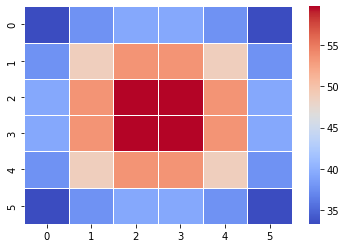

In [11]:
#Archivo donde se llama a la funcion galerkin y se hacen pruebas numericas
#import pandas as pd


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from Mesh import * #Archivo donde esta la función para generar malla y para graficar
from sympy import integrate, linear_eq_to_matrix, symbols,simplify,collect,  diff, Eq, Matrix
from sympy import *
from GalerkinFuntion import *

from numpy import *
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

#from GalerkinFuntionNormalizado import *

l = 0.6 #Distancia en x
#l=symbols('l')
w = 0.6 #Distancia en y
#w=symbols('w')
p = 5  #Divisiones en x
m = 5  #Divisiones en y

elemLength = l/p #Largo del elemento
elemWidth = w/m  #Ancho del elemento
tipoDeElemento = 'CUADRADO' #Puede ser elemento tipo 'TRIANGULO' o 'CUADRADO'

#Se genera la lista NL ("Node list") que contiene las coordenadas de cada nodo
#y EL("Element list") que contiene la lista de nodos de cada elemento

NL,EL = uniform_mesh(l, w, p, m, tipoDeElemento) # Generar malla

# graph_mesh(tipoDeElemento,NL,EL) #Graficar malla

#Definicion de condiciones iniciales

#kx=symbols('kx')
kx=1.2 #k conductividad en y
#ky=symbols('kx')
ky=1.2 #k conductividad en X

#Para caso donde la superficie es fuente de calor
#h=symbols('h')
h=20 #h Coeficiente de conveccion
#Tf=symbols('Tf')
Tf=30 #Tf Temperatura del aire 
#q=symbols('q')
q=1000 #q Flujo especifico de calor Vatios/m3  

#Para caso donde el calor viene del ambiente:
# h=-20 #h Coeficiente de conveccion
# Tf=100 #Tf Temperatura del aire 
# q=-100 #q Flujo especifico de calor Vatios/m3 




eqSist=[]
dataFrame=pd.DataFrame()

listaLadosConv=[True,True,True,True] #Lados i-j, j-m, m-n, n-i Lista con lados con conv

dataFrameList = []  #Se juntan las dataframe de cada elemento en una lista dataFrameList
for i in range (0, len(EL)):
    dataFrameList.append(galerkinMethod(elemLength, elemWidth, NL, EL, h, Tf, kx, ky, q, i,l,w, listaLadosConv ))

#print(dataFrameList)

#Nuevo dataframe juntando todas las dataFrame con elementos. Teniendo 4x#El ecuaciones
DataFrame = pd.concat(dataFrameList, axis=0)

#Las ecuaciones se suma deacuerdo a los nodos, para tener #Nodos ecuaciones
CompressedDF = DataFrame.replace(np.nan,0) #0 donde no hay termino
CompressedDF = DataFrame.groupby("nodo").sum() #suma por columna nodo
#CompressedDF.to_excel("ef.xlsx") #Para visualizar dataFrame comprimido
#DataFrame.to_excel ("ef2.xlsx" ) #Para visualizar dataFrame original

#Generación de matrices
matrixFinal = np.matrix(CompressedDF.drop('indep', inplace=False, axis=1)) #Matriz de coeff final
vectorFinal = np.array(CompressedDF['indep']) #Vector independiente para la solucion 
CompressedDF.drop('indep', inplace=True, axis=1) #Eliminamos de CompressedDF la columna indep
TemperatureVector =np.array(CompressedDF.columns ) #Se genera un vector con las incognitas


#print(matrixFinal)
#print(vectorFinal)

#Se genera una lista para guardar como incognitas las temperaturas
listaTemperaturas=[]
listaprueba=[]
listaprueba2=[]
for i in TemperatureVector:
    listaTemperaturas.append(symbols(str(i)))
    listaprueba.append(str(i))

for ele in listaprueba:
  listaprueba2.append(int(ele[1:]))

#Para usar la funcion linsolve de numpy 
vectorFinal = vectorFinal.astype('float32')
matrixFinal = matrixFinal.astype('float32')

# print(TemperatureVector)
#Se resuelve el sistema de ecuaciones
result=np.linalg.solve(matrixFinal, vectorFinal)
# print(result)

matrixCalor = np.zeros((p+1, m+1))


listaSinOrden=[]
for i in range (0,len(listaprueba2)):
  listaSinOrden.append([listaprueba2[i],result[i]])

def getKey(item):
  return item[0]

listaOrdenada=sorted(listaSinOrden, key=getKey)

# print(listaOrdenada)

contador=0
for j in range(0,m+1):
    for i in range (0,p+1):
        matrixCalor[j,i]=listaOrdenada[contador][1]
        contador=contador+1

print(matrixCalor)

# plt.imshow(matrixCalor, cmap='hot', interpolation='nearest')
# plt.show()

ax = sns.heatmap(matrixCalor, linewidth=0.5,cmap="coolwarm")


plt.show()

NameError: name 'cf' is not defined

In [9]:
matrixCalor.iplot(kind='heatmap',colorscale='spectral',title='Cufflinks - Heatmap')

AttributeError: 'numpy.ndarray' object has no attribute 'iplot'